# Metric Analysis - Part:1

### Style Setting

In [1]:
%matplotlib inline

# CSS File
from IPython.core.display import HTML
from IPython.display import Image
css = open('styles/style-table.css').read() + open('styles/style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [2]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Toggle Code On/Off"></form>''')

### Configuration

In [3]:
metric_name = "Disk Utilization (%)"
csv_name = 'data/du-5d.txt'

### Overview
The purpose of this notebook is explore various facets of any metric like 
- What is its average, minimum, maximum & frequent values of the metric under consideration?.
- What is the shape and personality of the metric? 
- How many distinct workload (ex: bootstrom etc) profiles in this metric? 
- What is this range and variation of this metric? tight, wide etc.
- What is the trend, seasonality and noise embedded in this metric?
- Is it flat, up or down trend? What is the persistency?
- When and how often the recurring cycles (ex: bootstorm) happen? 
- How many varieties of recurring cycles?
- How does this metric behave by hour of the day? by day of the week? etc..

Broadly we have 3 types of Analytics -

1. **Descriptive Analytics**
2. **Predictive Analytics**
3. **Prescriptive Analytics**

In this notebook, we focus on the **Descriptive Analytics** part. The other two are for future notebooks.

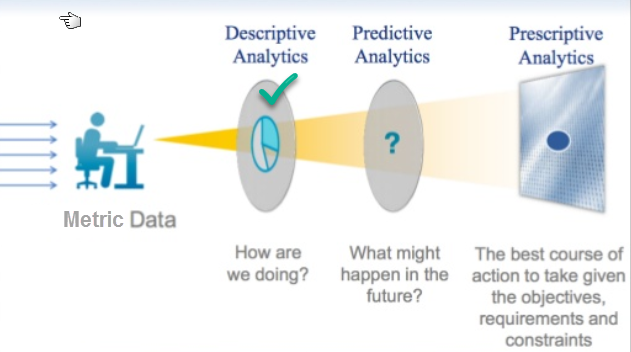

In [4]:
Image(filename='images/data-analytics-types.png', width=400,height=400)

**Note1:**
- This notebook uses **Disk Utilization (%)** metric as an example but is applicable to other metrics also.
- To use this notebook with a different metric, update the config section in the notebook and run it.
- If your interest is in multi-metric relations and analysis etc, please look at the another notebook for examples.

**Note2:**

I have included info on how to analyze in each section but if needed please see following Appendixes for more details on these visualizations
- Appendix - Box Plot Overview
- Appendix - Shape Plot Overview
- Appendix - Violin Plot Overview

### Libraries & Functions...

In [5]:
# Libraries
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import pandas_datareader.data as web
import datetime
from matplotlib.dates import DayLocator, HourLocator, MinuteLocator, AutoDateLocator, DateFormatter
from seasonal import fit_seasons, adjust_seasons, fit_trend

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm

sns.set(style="ticks", color_codes=True)
sns.set_context("notebook")
sns.set_style("darkgrid")

def read_metric_data(metric_name, csv_name):
    '''
        Read metric data from a given csv file.
        CSV format: [server_name, timestamp, value]
        Timestamp format: YYYY-MM-DD HH:mm:SS
        Lines begining with # are ignored as comments.
    '''
    
    # Read from csv file.
    df = pd.read_csv(csv_name, index_col=1, parse_dates=True, names=[ 'server', 'value'], comment='#', quotechar="'", sep=",")
    if(df.isnull().value.any()): 
        #print ("{0} - missing data row count#: {1}".format(csv_name, np.count_nonzero(df1.isnull().values)))
        df = df.fillna(method='ffill', limit=2) # Fill last value upto two consequtive slots
        
    print("{0} - #Observations: {1}".format(csv_name, df.shape))
    return df

def describe_metric(metric_name, df):
    '''
        Generate custom summary of the data
    '''
    summary = df.describe(percentiles=[0.05,0.25,0.5,0.75,0.95])
    summary.columns = [metric_name]
    summary = summary.applymap('{:.2f}'.format) # URL: https://pyformat.info/
    #summary['value'] = summary['value'].map('{:.2f}'.format) 
    summary.drop(labels=['count'], axis=0, inplace=True)
    summary.loc['frequent'] = df.mode().value[0]
    summary.loc['skewness'] = df.value.skew()
    summary.loc['kurtosis'] = "{0:.2f}".format(round(df.value.kurtosis(), 2))
    summary = summary.rename(index={'mean':'average', 'std':'std dev', 'min':'lowest', 'max':'highest'})
    return summary

def create_summary_plot(metric_name, summary):
    summary = summary.T
    summary = summary.iloc[:,:-2]
    fig = plt.figure(figsize=(10, 5))
    g = sns.barplot(data=summary, color='steelblue')
    g.set_ylabel(metric_name, fontweight='bold', fontsize=12)
    g.set_xlabel('Summary', fontweight='bold', fontsize=12)
    return
    
def create_line_plot(metric_name, series):
    '''
        Create line plot using seaborn
    '''
    # Create line chart
    fig = plt.figure(figsize=(12, 5))
    ax = plt.gca()
    ax.xaxis.set_major_locator(HourLocator(interval=6))
    ax.xaxis.set_major_formatter(DateFormatter('%m/%d %I:%M %p')) # TimeFormat : http://strftime.org/
    plt.plot(series, color='steelblue')
    #plt.xlabel("timestamp", fontweight='bold')
    plt.ylabel(metric_name, fontweight='bold')
    plt.gcf().autofmt_xdate()
    return

def create_box_plot(metric_name, df):
    plt.figure(figsize=(6,6))
    
    g1 = sns.boxplot(y=df.value, linewidth=2, color='lightsteelblue')
    g1.set_ylabel(metric_name, fontweight='bold', fontsize=12)
    g1.set_title("Range & Outliers", fontweight='bold', fontsize=12) 
    return

def create_shape_plots(metric_name, df):
    '''
        Creates various shape plots for a metric
    '''
    #Distribution Plot
    plt.figure(figsize=(6,6))
    g2 = sns.distplot(df.value, bins=30, kde=True, rug=True);
    sns.kdeplot(df.value, shade=True, color=".3");
    g2.set_xlabel(metric_name, fontweight='bold', fontsize=12)
    g2.set_title("Shape & Personality", fontweight='bold', fontsize=12)

    # Swarm Plot
    plt.figure(figsize=(6,6))
    g1 = sns.stripplot(data=df, jitter=True, size=4, color=".1", linewidth=0)
    g1.set_ylabel(metric_name, fontweight='bold', fontsize=12)
    g1.set_title("Distribution", fontweight='bold', fontsize=12)

    # Violin Plot
    #plt.figure(figsize=(6,6))
    g3 = sns.violinplot(data=df, palette=sns.color_palette(), split=True)
    g3.set_ylabel(metric_name, fontweight='bold', fontsize=12)
    g3.set_title("Distribution Behavior", fontweight='bold', fontsize=12)
    return

def plot_shapes():
    df1 = read_metric_data("Disk_Utilization", "data/du-5d.txt")
    df2 = read_metric_data("write_bytes_per_sec", "data/wbs_5d.txt")
    df3 = read_metric_data("read_bytes_per_sec", "data/rbs_5d.txt")

    composite = pd.concat([df1.value, df2.value, df3.value], axis=1, join_axes=[df1.index])
    composite.columns = ["Disk_Utilization", "Write_Bytes_Sec", "Read_Bytes_Sec"]
    composite.index.name = "timestamp"
    composite.head()
    
    #Distribution Plot
    fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
    sns.set_palette(sns.color_palette("muted"))
    fig.subplots_adjust(hspace=.5)
    fig.tight_layout()
    g1 = sns.kdeplot(df1.value, shade=True, ax=ax1);
    g1.set_xlabel(composite.columns[0], fontweight='bold', fontsize=12)
    g2 = sns.kdeplot(df2.value, shade=True, ax=ax2);
    g2.set_xlabel(composite.columns[1], fontweight='bold', fontsize=12)
    g3 = sns.kdeplot(df3.value, shade=True, ax=ax3);
    g3.set_xlabel(composite.columns[2], fontweight='bold', fontsize=12)
    
    #Violin Plots
    fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
    fig.subplots_adjust(hspace=.5)
    fig.tight_layout()
    g1 = sns.violinplot(data=composite.Disk_Utilization, ax=ax1)
    g1.set_xlabel(composite.columns[0], fontweight='bold', fontsize=12)
    g2 = sns.violinplot(data=composite.Write_Bytes_Sec, ax=ax2)
    g2.set_xlabel(composite.columns[1], fontweight='bold', fontsize=12)
    g3 =sns.violinplot(data=composite.Read_Bytes_Sec, ax=ax3)
    g3.set_xlabel(composite.columns[2], fontweight='bold', fontsize=12)
    return

def tsplot(y, lags=None, figsize=(10, 8)):
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(1.5) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()
    return ts_ax, acf_ax, pacf_ax


def decompose_ts(df, period=24, min_ev=0.05):
    # Detrend and Deseasonalize
    seasons, trend = fit_seasons(df.value, period=period, min_ev=min_ev)
    adjusted = adjust_seasons(df.value, period=period, seasons=seasons)
    residual = adjusted - trend
    return (seasons, trend, adjusted, residual)

def create_seasonal_plots(metric_name, period, df):
    (seasons, trend, adjusted, residual) = decompose_ts(df, period=period, min_ev=0.01)
    
    sns.set_palette(sns.color_palette("muted"))
    f, axarr = plt.subplots(5, figsize=(12, 12))
    f.subplots_adjust(hspace=.5)

    axarr[0].plot(df.value)
    axarr[0].set_title(metric_name + '   (Observed)')

    axarr[1].plot(adjusted)
    axarr[1].set_title(metric_name +'    (without cycles)')

    axarr[2].plot(residual)
    axarr[2].set_title(metric_name + '   (Noise)')

    axarr[3].plot(pd.Series(fit_trend(df.value)))
    axarr[3].set_title(metric_name + '   (Trend)')

    axarr[4].plot(seasons)
    axarr[4].set_title(metric_name + '   (Seasonality)')
    axarr[4].set_autoscalex_on(False)
    axarr[4].xaxis.set_major_locator(ticker.MultipleLocator(2))
    return

def create_seasonal_profile(metric_name, df):
    df['Hour'] = df.index.hour
    df['Day'] = df.index.dayofweek

    dfp1 = pd.pivot_table(df, index=["Hour"], values="value", aggfunc=[np.mean, np.min, np.max, np.std])
    dfp1.columns =['Average','Minimum','Maximum', 'Variation']
    dfp1['Range'] = dfp.Maximum - dfp.Minimum

    axarr = dfp1[['Average','Range','Variation']].plot(subplots=True, kind='bar', figsize=(12, 8), color=sns.color_palette(), fontsize='12', title = "Metric Profile (By HOUR of DAY)")
    for i in range(0,3):
        axarr[i].set_ylabel(metric_name)

    dfp2 = pd.pivot_table(df, index=["Day"], values="value", aggfunc=[np.mean, np.min, np.max, np.std])
    dfp2.columns =['Average','Minimum','Maximum', 'Variation']
    dfp2['Range'] = dfp.Maximum - dfp.Minimum

    axarr = dfp2[['Average','Range','Variation']].plot(subplots=True, kind='bar', figsize=(12, 8), color=sns.color_palette(), fontsize='12', title = "Metric Profile (By DAY of WEEK)")
    for i in range(0,3):
        axarr[i].set_ylabel(metric_name)
    return


### Data - Load & Clean

In [6]:
# Load data
df1 = read_metric_data(metric_name, csv_name)
df1.value = df1.value.round(3)

df = df1.copy()
df['value'] = df['value'].map('{:.2f}'.format) 

print('Input Data Sample:')
df.head()

IOError: File data/du-5d.txt does not exist

### Quick Visual Analysis

Let's start with a simple visual analysis using our trusty old line plot to answer questions like..  
- Any gaps in our data?
- Any corruptions in our data?
- Is the metric in a range? Or is it a trending metric?
- Any visually notable stuff in this metric? 

In [ ]:
create_line_plot(metric_name, df1.value)
print("#Observations:{0}".format(df1.value.count()))

### Summary Stats

-------------
Summary questions to start our analysis i.e., 
- What are the average and median (i.e., center) values for the metric? 
- Which value occurs most frequently for the metric? 
- What are the typical boundaries (i.e., min & max) of values for this metric?
- What is the typical variability of values (i.e., standard deviation) for this metric?
- What are its percentiles especially the bottom 5th & top 95th percentile values?

-------------

In [ ]:
summary = describe_metric(metric_name, df1)
create_summary_plot(metric_name, summary.copy())
summary.T

#### How to Intrepret:

The **5%, 25%, 50%, 75%, 95%** are the percentile values for the metric. Notice what values are the top and bottom percentiles. Similarly see which value shows up frequently. 

The **average** value can be misleading if there are too many spikes. **50%** is a more robust indication of the center. Small difference between **average** and **50%** is a good indication this metric behaves uniformly (atleast in the provided input sample) and can put

Notice the st

***Skewness*** quantifies how symmetrical the distribution is. It provides an indication of the direction the extreme observations can occur.

- A symmetrical distribution has a skewness of **zero**.
- An asymmetrical distribution with a long tail to the right (higher values) has a **positive skew**.
- An asymmetrical distribution with a long tail to the left (lower values) has a **negative skew**.
  
If metric distribution is symmetric, following applies (note: std dev value in above table):
- 66% of time observations are within 1 standard deviation. 
- 95% of time observations are within 2 standard deviations; 
- 99% of time observations are within 3 standard deviations;


Rest of the rows in the table are self-explanatory. 


In [ ]:
create_box_plot(metric_name, df1)
print("Note: Please see Appendix-BoxPlot for details on box-whisker-plots")

-----------------------
**How to Intrepret:**
- **Width** of the box above shows range of values that occur commonly for this metric. Is it tighter or wider?
- **Distance** between horizontal lines show range of values for this metric. Same question - tighter or wider, how far from the box etc?
- **Dots** show the outliers (or suspected outliers). How far are the outliers from horizontal bars? How many and how separated these outliers are from each other? This will provide an idea what to expect when it comes to outliers.

-----------------------

### Metric Shape & Personality
-------------
This section typically answer questions like i.e., 
- What is the shape of the metric i.e., symmetric or assymetric? 
- If it is asymetric, in which direction the tails are extended? Longer tail = Higher extremes
- How many peaks are in the distribution? Each peak represents a distinct load (ex: io storm).
- What is its personality i.e., is it smooth, zagged or bi-polar when making transistions from peaks?
- How much does this metric vary i.e., does it operate in a narrow range or is it wild-west?

-------------

In [ ]:
plot_shapes()

-----------------------
**How to Intrepret:**

**Top Row (Kernel Density Plots)**:
* The shaded areas in top row, is the **shape** of the work as captured by this metric. Similar workloads will have similar shapes. The shape could be uniform, zagged and myriad other forms. 
* The **transitions** from peak-to-valley and viceversa of the shaded area reflect the **personality** of the workload. It could be smooth or abrupt, bi-polar or balanced and myriad other ways. 
* The number of bumps show the **number of workloads** with distinct profiles.

**Bottom Row (Violin Plots)**:
* The width of the body is proportional to **probability** with which a particular metric value appears in the data. 
* The height of the body is proportional to **range** of the values seen in data.
* The dots represent the **actual values** of the metric in the given dataset.
* The number of peaks show the **number of workloads** with distinct profiles.
* The transistions from peak-to-valley and vice versa show how 

*A violin plot is a method of plotting numeric data. It is a box plot except it also show the probability density of the data at different values (in the simplest case this could be a histogram). Typically violin plots will include a marker for the median of the data and a box indicating the interquartile range, as in standard box plots. Overlaid on this box plot is a kernel density estimation.*

-----------------------

### Metric Decomposition -  Trend, Cycles & Noise

In [ ]:
create_seasonal_plots(metric_name=metric_name, period=48, df=df1)

**How to Intrepret:**

The above provides a wealth of information. Any metric data is made up of 3 things - ***Trend, Seasonality & Noise***. 

Note: Purists may find an objection that we are lumping seasonality & cyclicity together but that is fine.

- The **SEASONALITY** chart (bottom most) will provide how many distinct cycles (ex: iostorms) are in this metric and how far apart they happen.

- The **TREND** chart will provide insight into whether there is any trend if we strip away the noise & seasonality. 
    - If no trend, then we can expect not much change in future. Ex: Disk utilization might be more or less same. 
    - If trend exists, we need to account this into future forecasts. That is the primary variable.
- The **NOISE** chart will provide insight into the randomness part of the workload this metric is reflecting.

### Metric - Auto Correlations

In [ ]:
(seasons, trend, adjusted, noise) = decompose_ts(df1)
axarr = tsplot(noise, lags=24)

**How to Intrepret**:

**Auto Correlation** measures if there is any serial dependence between metric values & dependency strength i.e., does metric value at time-N is influenced by value at time-0 and by how much. The x-axis is the number of data points away i.e., N.

**Partial Auto Correlation*** measures 
This plot measures if there is any serial dependency (i.e., pattern or structure) in the noise component we extracted under seasonal plots. If there is a structure then it is not truly noise and we missed extracting fully the trend and cyclical components of the metric.

If the AutoCorrelation and Partial AutoCorrelations are closer to zero (ex: -2 to 2), then it means not much serial dependence left in the data.

*Why is this info useful to know?*

- Provides confidence in the trend & cyclicality components identified in previous section. 
- Another reason - helps on the forecast side like ARIMA(1) etc. 


### Metric Profile

In [ ]:
create_seasonal_profile(metric_names[0], df1.copy())

**How to Intrepret**:

- IMO the above visualizations are quite useful and can be used in many ways.
- Use this in conjunction with the shape & seasonality visualizations for deeper insights.


### Summary

### Appendix - Box Plots Overview

In [ ]:
Image(filename='images/overview-boxplot.png')

### Appendix - Density Plot Overview

In [ ]:
Image(filename='images/overview-densityplot.png')

### Appendix - Violin Plot Overview

In [ ]:
Image(filename='images/overview-violinplot.png')